## Lindgren, Eric
## 970222-1954

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting
import emcee

import scipy.optimize as opt

# Problem 5

## Task a)

Text(0.5, 1.0, 'Generated data')

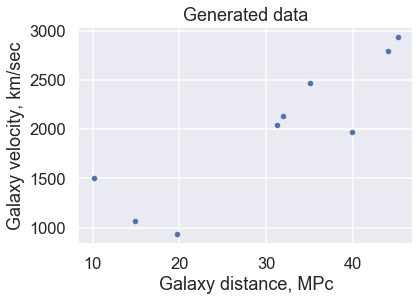

In [16]:
# Data from student lab observations; 
# x = Galaxy distances in MPc
# y = Galaxy velocity in km/sec
x = np.array([10.1 ,45.2, 19.7, 31.2, 31.9, 44.0,
       14.9, 35.1,  39.9  ])
y = np.array([1507.9, 2937.5,  930.4, 2037.1, 2131.1,
       2795.6, 1061.8, 2464.8, 
       1971.1])
sigma = 200

# Plot data
fig, ax = plt.subplots()
ax.plot(x,y, 'b.', label='Data')
ax.set_xlabel("Galaxy distance, MPc")
ax.set_ylabel("Galaxy velocity, km/sec")
plt.title("Generated data")

No error on x, and a constant standard deviation of $\sigma$ on y. This makes the probability to measure a certain datapoint to be normally distributed around the model value: 

$$p(x_i,y_i|M, I) \sim N(y_M(x_i;\theta), \sigma) $$

where $\theta$ are the model parameters. The total likelihood is thus:

$$ \log{p(D|M,I)} = \log{\prod_{i=0}^{N-1}p(x_i, y_i|M,I)} = -N \log{\sqrt{2\pi\sigma^2}} + \sum_{i=0}^{N-1} \frac{-[y_i-y_M(x_i;\theta)]}{2\sigma^2}  $$

We make the prior that the data can be fitted with a straight line. Thus our model $M$ only has two parameters in $\theta$: the intercept $m$ and the slope $k$. Hubbles law states that $y = H_0 \cdot x$, which means that we are only really interested in $k$.

#### Step 1: Maximum likelihood estimate

In [17]:
# return a simple maximum likelihood estimate
def log_likelihood(theta, x, y, sigma):
    term_1 = -len(x)*np.log(2*np.pi*sigma**2)
    y_M = theta[0]*np.ones((len(x))) + theta[1]*x
    term_2 = (-(y-y_M)**2/(2*sigma**2)).sum()
    return term_1 + term_2


def negative_log_likelihood(theta,x,y,sigma):
    return -log_likelihood(theta, x, y, sigma)

# Maximize using scipy optimize
max_like_est = opt.minimize(negative_log_likelihood, [0,0], args=(x, y, sigma))
display(f'Maximum likelihood approach yields: m, k={max_like_est.x}')

'Maximum likelihood approach yields: m, k=[506.32926036  48.824909  ]'

The maximum likelihood estimate for the Hubble constant is $H_0 \approx 48.8$.

#### Step 2: Bayesian analysis

In [18]:
# define log of prior, use log likelihood from step 1. We do not care 
# about the normalization in Bayes theorem.
def log_prior_intercept(m, sigma):
    fun = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(np.abs(m)**2)/(2*sigma**2))
    return np.log(fun)


def log_prior_slope(k):
    fun =  1/(1+k**2)**(3/2)
    return np.log(fun)


def log_posterior(theta, x, y, sigma):
    log_like = log_likelihood(theta, x, y, sigma)
    # Assume m and k to be independent. Then their joint pdf is the product
    # of the two.
    log_prior = log_prior_intercept(theta[0],sigma) + log_prior_slope(theta[1])
    return log_like + log_prior


def negative_log_posterior(theta, x, y, sigma):
    return -log_posterior(theta,x,y,sigma)

# We want to maximize these and find their respective modes. Especially 
# for the slope.
# Use scipy optimize as in step 1 again:
max_bayesian_approach = opt.minimize(negative_log_posterior, [0,0], args=(x, y, sigma))
display(f'Bayesian approach yields: m, k={max_bayesian_approach.x}')

'Bayesian approach yields: m, k=[306.45253168  54.31160937]'

#### Step 3: Bayesian approach to Outliers (good-data/bad-data)

In [22]:
def complicated_likelihood(m, k, g, e, x, y, sigma):
    if (g > 0).all() and (np.abs(g) <= 1).all():
         # eps, g, m, k are all numbers here. prod over x & y!
        # We have a list of gi and epsilon. For each of them calculate their corresponding datapoint
        data_terms = np.zeros((len(x)))
        for i in range(len(x)):
            y_M = m + k*x[i]
            gauss = 1/np.sqrt(2*np.pi*e[i]**2)*np.exp(-((y_M-y[i])**2)/(2*e[i]**2))
            lorentz = 1/(np.sqrt(2)*np.pi*sigma)*1/(1+((y_M-y[i])**2)/(2*sigma**2))
            # The likelihood is the product over all i
            data_terms[i] = g[i]*(gauss) + (1-g[i])*lorentz
        return np.prod(data_terms)
    else:
        # This corresponds to g being outside the valid interval
        return 0
    
    
def log_complicated_likelihood(input_vec, x, y, sigma):
    m = input_vec[0]
    k = input_vec[1]
    g = input_vec[2:2+len(x)]
    e = input_vec[2+len(x):]
    #print(f'Length of g {len(g)}')
    #print(f'Length of e {len(e)}')
    fun = complicated_likelihood(m, k, g, e, x, y, sigma)
    return np.log(fun)


# Use an emcee sampler to explore the parameter space for this pdf. 
# Study the log of this pdf
import emcee

ndim = 2+len(x)+len(x) # m, k, {gi}, {ei}
nwalkers = 3*ndim  # nbr of mcmc walkers
# Randomize the starting position in eps, g, k, m, space
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
# Define the sampler
arglist = (x, y, sigma)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_complicated_likelihood, args=arglist)
# Burn-in
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Start the walk
sampler.run_mcmc(pos, 2000)
print("Done sampling")

C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


Done sampling


In [24]:
#****************************** OLD CODE ****************************
# Code version with one g and eps for each m and k - gives a much better answer
def complicated_likelihood(m, k, g, eps, x, y, sigma):
    if g > 0 and np.abs(g) <= 1:
         # eps, g, m, k are all numbers here. prod over x & y!
        y_M = m*np.ones((len(x))) + k*x
        gauss = 1/np.sqrt(2*np.pi*eps**2)*np.exp(-((y_M-y)**2)/(2*eps**2))
        lorentz = 1/(np.sqrt(2)*np.pi*sigma)*1/(1+((y_M-y)**2)/(2*sigma**2))
        # The likelihood is the product over all i
        prod = np.prod(g*(gauss) + (1-g)*lorentz)
        return prod
    else:
        # This corresponds to g being outside the valid interval
        return 0
    
    
def log_complicated_likelihood(input_vec, x, y, sigma):
    m = input_vec[0]
    k = input_vec[1]
    g = input_vec[2]
    eps = input_vec[3]
    fun = complicated_likelihood(m, k, g, eps, x, y, sigma)
    return np.log(fun)

# **************************
eps = 1 # TODO what to do with eps
# TODO using one g for all data points, not each of them 
# **************************

# Use an emcee sampler to explore the parameter space for this pdf. 
# Study the log of this pdf
import emcee

ndim = 4 # m, k, g, eps
nwalkers = 10  # nbr of mcmc walkers
# Randomize the starting position in eps, g, k, m, space
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
# Define the sampler
arglist = (x, y, sigma)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_complicated_likelihood, args=arglist)
# Burn-in
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Start the walk
sampler.run_mcmc(pos, 2000)
print("Done sampling")
#********************************************************************

C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Done sampling


(10, 2000, 4)
55.492454519999654


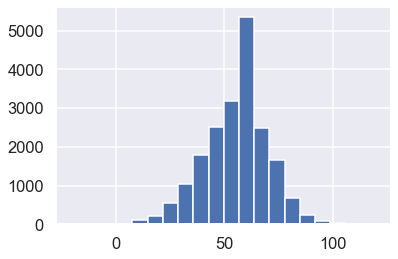

In [26]:
print(sampler.chain.shape)
# Marginalize out m, g and plot k - do this by dropping the required columns
k_samples = np.copy(sampler.chain[:,:,1])
# Flatten array to get info from all 10 walkers
k_samples = k_samples.flatten()

# Create a histogram
fig, ax = plt.subplots()
ax.hist(k_samples, 20)
H0 = k_samples.mean()
print(H0)

## Task b

The distance to the galaxy for case one is given by the pdf in the figure, with mode 1800.0 MPc.


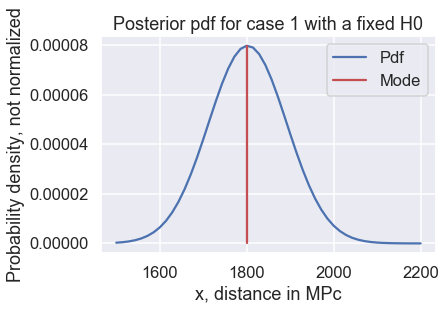

In [30]:
# Case 1 - here we assume H0 to be "perfect", with no error
def posterior_case1(x, vmeasured, sigmav, H0):
    fun = 1/(np.sqrt(2*np.pi)*sigmav)*np.exp(-(np.ones((len(x)))*vmeasured-H0*x)**2/(2*sigmav**2))
    return fun
    
x_min = 1500  # Mpc
x_max = 2200 # MPc
x = np.linspace(x_min, x_max, 50)

vm = 100000  # km/sec
sig_vm = 5000  #

# Plot the posterior pdf
fig, ax = plt.subplots()
posterior_pdf = posterior_case1(x, vm, sig_vm, H0)
# calc mode of pdf
mode_idx =np.argmax(posterior_pdf)
mode_pos = x[mode_idx]
mode_height = np.amax(posterior_pdf)
ax.plot(x, posterior_pdf, label="Pdf")
ax.plot([mode_pos,mode_pos], [0,mode_height], 'r', label="Mode")
plt.legend()
ax.set_xlabel("x, distance in MPc")
ax.set_ylabel("Probability density, not normalized")
plt.title("Posterior pdf for case 1 with a fixed H0")

print(f'The distance to the galaxy for case one is given by the pdf in the figure, with mode {round(mode_pos)} MPc.')

The distance to the galaxy for case one is given by the pdf in the figure, with (one of the) mode(s) 1687.0 MPc.


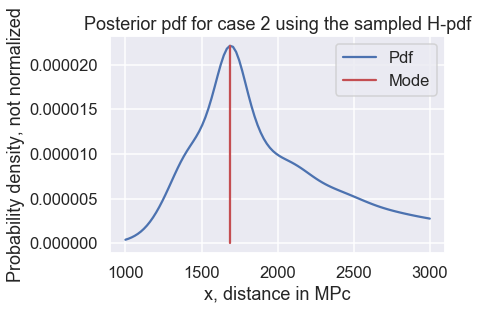

In [29]:
# Case 2
# In our case, p(D|Hi,I) = p(y|x,Hi,I), the likelihood for measuring our data. 
# We utilize the fact that the datapoint is distributed according to a Gaussian with mean 0 and standard deviation sigmav
# But this is just the posterior for case1, so we use it again.

def posterior_case2(x, vmeasured, sigmav, H):
    posterior_pdfs = np.zeros((len(H), len(x)))
    # Iterate over all Hi, calculate the likelihood for each of them and add them over all Hi. 
    # Then divide by 1/len(H)
    for idx, Hi in enumerate(H):
        likelihood = posterior_case1(x, vmeasured, sigmav, Hi)
        posterior_pdfs[idx,:] = likelihood[:]
    post_sum = posterior_pdfs.sum(axis=0)  # Sum over the H axis
    return post_sum/(len(H))

x = np.linspace(1000,3000, 100)
H = k_samples  # All samples of H
posterior_pdf = posterior_case2(x, vm, sig_vm, H)
mode_idx =np.argmax(posterior_pdf)
mode_pos = x[mode_idx]
mode_height = np.amax(posterior_pdf)


fig, ax = plt.subplots()
ax.plot(x, posterior_pdf, label="Pdf")
ax.plot([mode_pos,mode_pos], [0,mode_height], 'r', label="Mode")
plt.legend()
ax.set_xlabel("x, distance in MPc")
ax.set_ylabel("Probability density, not normalized")
plt.title("Posterior pdf for case 2 using the sampled H-pdf")
print(f'The distance to the galaxy for case one is given by the pdf in the figure, with (one of the) mode(s) {round(mode_pos)} MPc.')

# Problem 6

The autocorrelation function $p(h)$ calculates how often we return to the same points. The summation is taken over the overlapping subsets. I.e. if we go to point $x$ at $t=1$ and return there at $t=10$, these samples overlap. $h$ is a discrete parameter which is called the lag, which is a shift. ($X_t-\bar{X}$) is the difference between Xt and the mean value of all the samples. The expression is large if both $X_t$ and $X_{t+h}$ are close to the mean, for all overlapping samples. This would corresponds to a lot of samples being taken very close to each other. In the other end, we would get a low p(h) if all of the values are taken far away from each other (far away from the mean).